<a href="https://colab.research.google.com/github/Subangkar/Image-Captioning-Attention-PyTorch/blob/main/demo_attention_flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo

In [1]:
MODEL_DIR = 'saved_models/resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300/'
MODEL_NAME = 'resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300_best_train.pt'

In [20]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets.flickr8k import Flickr8kDataset
from metrics import *
from utils_torch import *
from utils_plot import visualize_att
import numpy as np
import itertools

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
DATASET_BASE_PATH = 'data/flickr8k/'

In [5]:
vocab_set = pickle.load(open(MODEL_DIR+'vocab_set.pkl', 'rb')) if os.path.exists(MODEL_DIR+'vocab_set.pkl') else None
vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)
vocab_size, max_len

(7707, 40)

In [6]:
val_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set, device=device,
                          return_type='corpus',
                          load_img_to_memory=False)
test_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set, device=device,
                           return_type='corpus',
                           load_img_to_memory=False)
train_eval_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set, device=device,
                                 return_type='corpus',
                                 load_img_to_memory=False)
len(train_eval_set), len(val_set), len(test_set)

(6000, 1000, 1000)

In [7]:
EMBEDDING_DIM = 300
ATTENTION_DIM = 256
DECODER_SIZE = 256
BATCH_SIZE = 16

In [8]:
checkpoint = torch.load(os.path.join(MODEL_DIR, MODEL_NAME), map_location=torch.device('cpu'))

In [19]:
def words_from_tensors_fn(idx2word, max_len=40, startseq='<start>', endseq='<end>'):
    def words_from_tensors(captions: np.array) -> list:
        """
        :param captions: [b, max_len]
        :return:
        """
        captoks = []
        for capidx in captions:
            # capidx = [1, max_len]
            captoks.append(list(itertools.takewhile(lambda word: word != endseq,
                                                    map(lambda idx: idx2word[idx], iter(capidx))))[1:])
        return captoks

    return words_from_tensors

In [9]:
def evaluate_model(data_loader, model, loss_fn, vocab_size, bleu_score_fn, tensor_to_word_fn, desc=''):
    running_bleu = [0.0] * 5
    model.eval()
    t = tqdm(iter(data_loader), desc=f'{desc}')
    for batch_idx, batch in enumerate(t):
        images, captions, lengths = batch
        outputs = tensor_to_word_fn(model.sample(images, startseq_idx=word2idx['<start>']).cpu().numpy())

        for i in (1, 2, 3, 4):
            running_bleu[i] += bleu_score_fn(reference_corpus=captions, candidate_corpus=outputs, n=i)
        t.set_postfix({
            'bleu1': running_bleu[1] / (batch_idx + 1),
            'bleu4': running_bleu[4] / (batch_idx + 1),
        }, refresh=True)
    for i in (1, 2, 3, 4):
        running_bleu[i] /= len(data_loader)
    return running_bleu

In [10]:
from models.torch.resnet101_attention import Captioner

final_model = Captioner(encoded_image_size=14, encoder_dim=2048,
                        attention_dim=ATTENTION_DIM, embed_dim=EMBEDDING_DIM, decoder_dim=DECODER_SIZE,
                        vocab_size=vocab_size,).to(device)
final_model.load_state_dict(checkpoint['state_dict'])
final_model.eval()

/home/sathvik/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sathvik/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

In [11]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_eval_set.pad_value).to(device)
sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)

eval_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.CenterCrop(256),  # get 256x256 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations

In [12]:
eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn)
train_eval_loader = DataLoader(train_eval_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn)

In [13]:
model = final_model
model.eval()

Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

References: ['a black dog is emerging from a red tunnel .', 'A border collie is running out of a red tunnel obstacle .', 'A dog peeks out of a red play tunnel .', 'Dog in folding red tunnel on grass .', 'The black and white dog sprints through the red parachute tunnel on the grassy field .']
pred: a black and white dog is running through a red tunnel . 


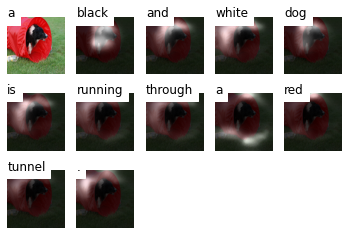

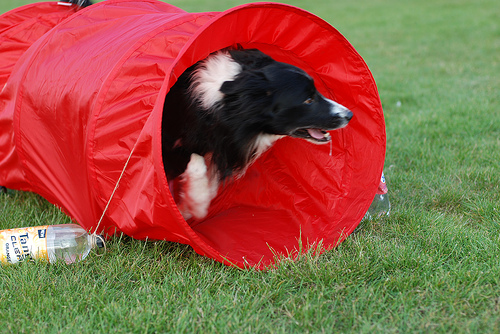

In [16]:
t_i = 15
dset = train_eval_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['A dog jumps to catch a red ball outside .', 'a small shaggy dog plays with a red ball on the grass .', 'A Yorkie trying to catch a red toy .', 'little dog is jumping up to catch a red ball in its mouth .', 'The dog jumps up to catch the red ball .']
pred: a small dog plays with a red ball in the grass . 


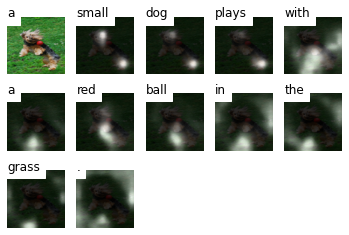

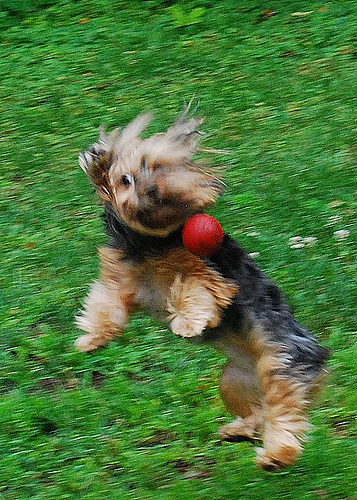

In [17]:
t_i = 500
dset = val_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['A group of people in a boat , white water rafting .', 'A group of seven people are rafting in the rapids in a green boat .', 'Rafting boat on river .', 'seven people are riding a green raft in a white water river .', 'Seven rafters are paddling and riding the rapids in a green raft .']
pred: a group of people are riding a raft in rough waters . 


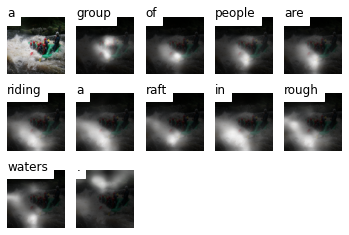

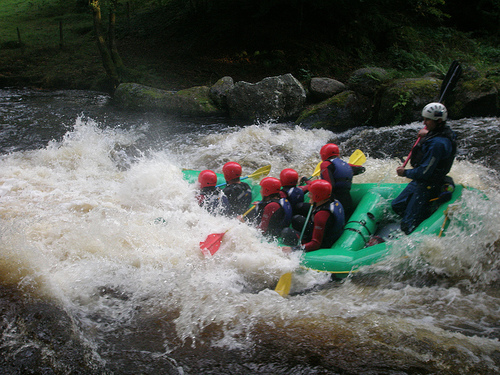

In [18]:
t_i = 500
dset = test_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

In [37]:
with torch.no_grad():
    model.eval()
    train_bleu = evaluate_model(desc=f'Train: ', model=final_model,
                                loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                                tensor_to_word_fn=tensor_to_word_fn,
                                data_loader=train_eval_loader, vocab_size=vocab_size)
    val_bleu = evaluate_model(desc=f'Val: ', model=final_model,
                              loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                              tensor_to_word_fn=tensor_to_word_fn,
                              data_loader=val_loader, vocab_size=vocab_size)
    test_bleu = evaluate_model(desc=f'Test: ', model=final_model,
                               loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                               tensor_to_word_fn=tensor_to_word_fn,
                               data_loader=test_loader, vocab_size=vocab_size)
    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'Bleu-{ngram}: {result[ngram]}', end=' ')
        print()

Train:   0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 